<a href="https://colab.research.google.com/github/Alexflames/frame-detection/blob/master/PersonalTask_frame_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Автор
Григорьев Алексей, 451 группа, КНиИТ

## Задание
С помощью машинного обучения научиться различать рамки у картин для последующего вырезания и превращения изображений картин с рамками в картины **без** рамок

### Часть 1 - классическое решение на OpenCV
##### **"Простой" набор данных**
[Первый набор данных](https://drive.google.com/open?id=19Wx9l9C6IovJ5n1OTYzmt39w5cmIgzHJ) представляет 200 "простых для обработки" изображений картин с рамками,
собраны в поисковике google, посредством отфильтрации подходящих вручную.
- **Все** картины имеют рамки;
- Картины **не** повернуты под углом;
- Может быть свободное пространство любого цвета **до** рамки, **после** рамки перед изображением;
- Рамки преимущественно монотонные, но также иногда встречаются объмные варианты;
- Возможно наличие теней или других эффектов окружающего мира на центральной части изображения / с какой-то стороны от картины;
- Форматы изображений `.jpg | .png | .webp`;
- Изображения разных размеров, разное соотношение сторон;
- Различная цветовая гамма.

##### **Программа**
Далее следуют фрагменты программы для решения задачи



**Шаг №1**

Загрузка изображений из гугл-диска по ссылке. Выбор X изображений из набора и вывод на экран.

Фрагмент с загрузкой файлов взят из практики 3 с курса по ML. Слегка модифицирован

In [1]:
from google.colab import auth
from googleapiclient.discovery import build
import io
from googleapiclient.http import MediaIoBaseDownload

def download_data(file_id, file_name):
  request = drive_service.files().get_media(fileId=file_id)
  downloaded = io.BytesIO()
  downloader = MediaIoBaseDownload(downloaded, request)
  done = False
  while done is False:
    _, done = downloader.next_chunk()
    
  downloaded.seek(0)
  with open(file_name, "wb") as f:
    f.write(downloaded.read())

  
auth.authenticate_user()
drive_service = build('drive', 'v3')

folder_name = 'pictureset_simple_1'
file_id = '1IfQwOLV2YLbBDSHYg7o4QkWHfcsz7GLi'
file_name = folder_name + '.zip'

download_data(file_id, file_name)
!mkdir pictureset_simple_1
!unzip pictureset_simple_1.zip -d pictureset_simple_1
!ls

adc.json  pictureset_simple_1  pictureset_simple_1.zip	sample_data


In [0]:
# Можно раскомментировать и запустить чтобы посмотреть структуру проекта 
# !ls

In [0]:
# Можно раскомментировать и запустить чтобы посмотреть структуру проекта 
# !ls pictureset_simple_1

Возьмем X изображений из папки `pictureset_simple_1` и выведем на экран

In [0]:
import os
filenames = []
for filename in os.listdir(folder_name):
  filenames.append(os.path.join(folder_name, filename))

Выборка X изображений.

Смените флаг `show_images` на True чтобы вывести выбранные изображения на экран

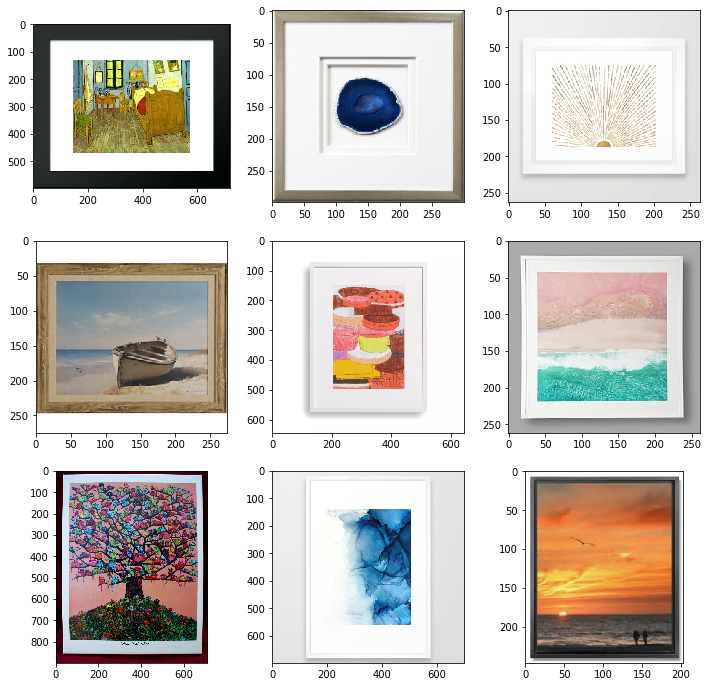

In [67]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

X = 9

random_index = np.random.choice(range(len(filenames)), X)
chosen_pictures = []

for i_normal, index in enumerate(random_index):
  img_picked = cv2.imread(filenames[index])
  chosen_pictures.append(img_picked)

# Блок вывода изображений на экран
test_show_images = True

def nearest_square(limit):
    answer = 0
    while (answer+1)**2 < limit:
        answer += 1
    return answer**2

def show_images(cv_images):
  X_nearest_square = nearest_square(X) - 1 # расположим X фигур в квадрате
  fig, axeslist = plt.subplots(ncols= X_nearest_square, nrows = X_nearest_square)
  
  for i in range(len(cv_images)):
    img_picked = cv_images[i]
    axeslist.ravel()[i].imshow(img_picked[:, :, ::-1]) # показ переведенного из BGR в RGB изображения
    #axeslist.ravel()[i].set_axis_off()
  
  plt.rcParams["figure.figsize"] = (12,12)
  plt.show()

if test_show_images:
  show_images(chosen_pictures)

С помощью средств OpenCV найдем рамки изображения, переведя Grayscale версию в ч/б с помощью функции `threshold`. Найденные контуры обрабатываются функцией `boundingRect` чтобы найти прямоугольник описывающий контур. К прямоугольнику предъявляются следующие условия:
- Его размер должен быть больше `size_threshold`
- Его центр должен быть удален от центра изображения не более чем на `eps_centre`

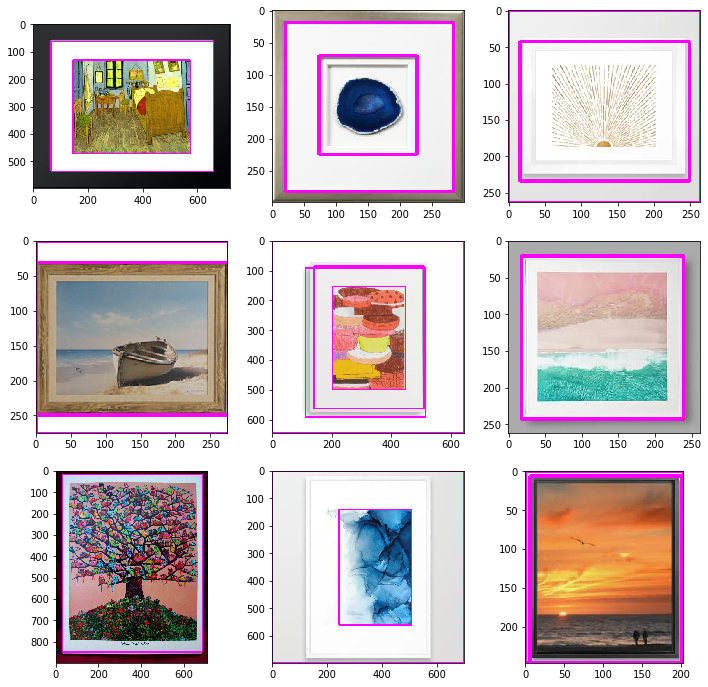

In [68]:
import cv2
import numpy as np

# Сортировка контуров по их длине
def sort_by_perimter(contour):
  return cv2.arcLength(contour, True)

size_threshold = 0.15
eps_centre = 0.04
def estimated_frames(img):
  imgGray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  ret,thresh = cv2.threshold(imgGray, 215, 255, 0)  # все что ниже границы становится черным, выше - белым
  _, contours, _ = cv2.findContours(thresh, 1, 2) # находим контуры

  contours.sort(key=sort_by_perimter, reverse=True)

  img_height = img.shape[0]
  img_width = img.shape[1]
  img_square = img_width * img_height
  
  boxes = []
  for cnt in contours:
    # ищем прямоугольник, описывающий контур
    x,y,w,h = cv2.boundingRect(cnt) # находим неповернутый прямоугольник, описывающий контур

    # проверка размера изображения (так как отсортированы, то можно полагать что все последующие не подходят)
    if w * h < img_square * size_threshold:
      break
    # проверка центрированности, допускается отклонение на epsilon от ширины и высоты
    cnt_center = (x + w/2, y + h/2)
    #print(abs(cnt_center[1] - img_width / 2), abs(cnt_center[0] - img_height / 2))
    if abs(cnt_center[0] - img_width / 2) > eps_centre * img_width  or abs(cnt_center[1] - img_height / 2) > eps_centre * img_height:
      continue  

    # преобразуем из (x y w h) в numpy array точек
    box = np.array([np.array([x, y]), np.array([x+w, y]), np.array([x+w, y+h]), np.array([x, y+h])])      
    box = np.int0(box) # так делают в интернете, переводят в целые числа
    boxes.append(box)

  return boxes

def img_with_contour(img):
  frames = estimated_frames(img)
  for box in frames:    
    cv2.drawContours(img, [box], 0, (255, 0, 255), 3)
  return img

images_contoured = []
for i in range(len(chosen_pictures)):
  image_proceed = chosen_pictures[i].copy()
  images_contoured.append(img_with_contour(image_proceed))
show_images(images_contoured)

### Архив
Содержит старые функции, которые показали худший результат по сравнению с актуальным. Решил не удалять код на всякий случай.

In [0]:
def img_with_contour1887(img):
  imgGray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  ret,thresh = cv2.threshold(imgGray, 200, 255, 0)  # все что ниже границы становится черным, выше - белым
  _, contours, _ = cv2.findContours(thresh, 1, 2) # находим контуры

  contours.sort(key=sort_by_perimter, reverse=True)
  n = 3
  cnts = contours[0:n] # выбираем первые n контуров
  for cnt in cnts:
    cv2.drawContours(img, [cnt], 0, (0, 0, 255), 3)
    # вариант 1 - но он ищет не минимум, вообще-то минимум но у меня почему-то нет
    x,y,w,h = cv2.boundingRect(cnt) # находим неповернутый прямоугольник, описывающий контур
    # преобразуем из (x y w h) в формат, принимаемый функцией отрисовки
    box = np.array([np.array([x, y]), np.array([x+w, y]), np.array([x+w, y+h]), np.array([x, y+h])])      
    cv2.drawContours(img, [box], 0, (0, 255, 0), 3)           

    # вариант 2 - возвращает минимальные но повернутые прямоугольники 
    # 2 точки в одномерном массиве, нужно в двумерном
    rect = cv2.minAreaRect(cnt) # находим прямоугольник (может повернутый), описывающий контур
    box = cv2.boxPoints(rect) # находим 4 вершины прямоугольника
    box = np.int0(box) # так делают в интернете, переводят в целые числа
    # принимает формат [[x1 y1] [x2 y2] [x3 y3] [x4 y4]]
    if (len([box]) > 0):
      cv2.drawContours(img, [box], 0, (255, 0, 255), 3)

  return img